In [2]:
event_dir = 'events4'

In [3]:
import sys, os
import numpy as np
import h5py as h5
import ROOT as rt

Welcome to JupyROOT 6.22/08


In [4]:
rt.gROOT.SetBatch(True)
rt.gStyle.SetOptStat(0)

In [5]:
path_prefix = os.getcwd() + '/../'
if(path_prefix not in sys.path): sys.path.append(path_prefix)
from util import qol_util as qu
from util.calcs import PxPyPzEToPtEtaPhiM, DeltaR2

In [6]:
colors = {
    'constituents': rt.kRed,
    'top': rt.kGreen,
    'bottom': rt.kOrange,
    'W': rt.kBlue,
    'jet': rt.kViolet
}

In [7]:
names = {
    'events1':'No MPI, no ISR/FSR',
    'events2':'No MPI, with ISR/FSR',
    'events3':'MPI and ISR/FSR',
    'events4':'test'
}

In [8]:
filename = '../{}/events.h5'.format(event_dir)
f = h5.File(filename,'r')
title = names[event_dir]

In [9]:
def GetJagged(pmu, nobj):    
    nentries_final = np.sum(nobj)
    result = np.zeros((nentries_final,pmu.shape[-1]))
    nentries = pmu.shape[0]
    
    counter = 0
    for i in range(nentries):        
        result[counter:counter+nobj[i],:] = pmu[i,:nobj[i],:]
        counter += nobj[i]
    return result  

In [10]:
# vecs are of form (eta, phi), one entry per event
def DeltaR(vec1, vec2):
    result = np.zeros(vec1.shape[0])
    for i in range(len(result)):
        result[i] = np.sqrt(DeltaR2(*vec1[i], *vec2[i]))
    return result

In [11]:
top = f['truth_Pdg'][:] == 6
bottom = f['truth_Pdg'][:] == 5
W = f['truth_Pdg'][:] == 24

# Number of constituents per event
nobj = f['Nobj'][:]

# Constituent momenta (throwing away the zero-padding).
pmu = GetJagged(f['Pmu'][:],f['Nobj'][:])

# particle energy
E = {
    'constituents':f['Pmu'][:,3].flatten(),
    'top':f['truth_Pmu'][:][top][:,3].flatten(),
    'bottom':f['truth_Pmu'][:][bottom][:,3].flatten(),
    'W':f['truth_Pmu'][:][W][:,3].flatten(),
    'jet': f['jet_Pmu'][:][:,3].flatten()
}

# particle px
px = {
    'constituents': f['Pmu'][:,0].flatten(),
    'top':f['truth_Pmu'][:][top][:,0].flatten(),
    'bottom':f['truth_Pmu'][:][bottom][:,0].flatten(),
    'W':f['truth_Pmu'][:][W][:,0].flatten(),
    'jet':f['jet_Pmu'][:][:,0].flatten()
}

# particle py
py = {
    'constituents': f['Pmu'][:,1].flatten(),
    'top':f['truth_Pmu'][:][top][:,1].flatten(),
    'bottom':f['truth_Pmu'][:][bottom][:,1].flatten(),
    'W':f['truth_Pmu'][:][W][:,1].flatten(),
    'jet':f['jet_Pmu'][:][:,1].flatten()
}

# particle pz
pz = {
    'constituents': f['Pmu'][:,2].flatten(),
    'top':f['truth_Pmu'][:][top][:,2].flatten(),
    'bottom':f['truth_Pmu'][:][bottom][:,2].flatten(),
    'W':f['truth_Pmu'][:][W][:,2].flatten(),
    'jet':f['jet_Pmu'][:][:,2].flatten()
}

p_cyl = {key: PxPyPzEToPtEtaPhiM(px[key],py[key],pz[key],E[key]) for key in E.keys()}
pt = {key: p_cyl[key][:,0] for key in E.keys()}
eta = {key: p_cyl[key][:,1] for key in E.keys()}
phi = {key: p_cyl[key][:,2] for key in E.keys()}
m = {key: p_cyl[key][:,3] for key in E.keys()}

f.close()

In [12]:
# Let's also get the ∆R between the jets and the truth-level particles (top is the most interesting).
dr = {
    key: DeltaR(p_cyl[key][:,1:3], p_cyl['jet'][:,1:3])
    for key in ['top','bottom', 'W'] # TODO: Order does matter when referencing in other scripts!
}

In [13]:
canvases = []
stacks = []
hists = []
legends = []

In [14]:
def KinematicDraw(keys, data, bin_info, title, logx=True, logy=True):
    c = rt.TCanvas(qu.RN(),'c0',800,600)
    legend = rt.TLegend(0.8,0.8,0.95,0.95)
    hstack = rt.THStack(qu.RN(),title)
    hlist = []
    nbins, xmin, xmax = bin_info
    
    dummy = {'a':'a'}
    
    if(type(keys) not in (list, type(dummy.keys()))): 
        keys = [keys]
        data = {keys[0]:data}

    for key in keys:

        h = rt.TH1F(qu.RN(),'',nbins,xmin,xmax)
        for elem in data[key]: h.Fill(elem)
        h.SetLineColor(colors[key])
        integral = np.maximum(h.Integral(),1.)
        h.Scale(1./integral)
        hstack.Add(h)
        legend.AddEntry(h,key,'l')
        hlist.append(h)

    hstack.Draw('NOSTACK HIST')
    legend.Draw()
    if(logx): c.SetLogx()
    if(logy): c.SetLogy()
    c.Draw()
    return c, legend, hlist, hstack

In [15]:
def KinematicDraw2D(data_x, data_y, bin_info, title, logx=True, logy=True):
    c = rt.TCanvas(qu.RN(),'c0',800,600)
    legend = rt.TLegend(0.8,0.8,0.95,0.95)

    nx, xmin, xmax, ny, ymin, ymax = bin_info
    
    dummy = {'a':'a'}
    
    h = rt.TH2F(qu.RN(),title,nx, xmin, xmax, ny, ymin, ymax)
    
    for i in range(len(data_x)):
        h.Fill(data_x[i], data_y[i])
        
    integral = np.maximum(h.Integral(),1.)
    h.Scale(1./integral)
    h.Draw('COLZ')
    if(logx): c.SetLogx()
    if(logy): c.SetLogy()
    c.SetLogz()
    c.SetRightMargin(0.15)
    c.Draw()
    return c, h

In [16]:
f = rt.TFile('{}.root'.format(event_dir),'RECREATE')

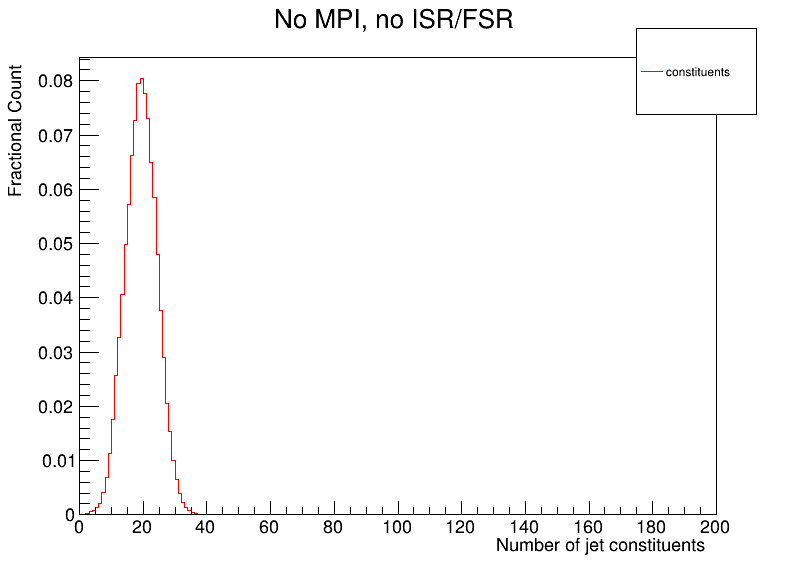

In [17]:
c, leg, hlist, hstack = KinematicDraw('constituents',nobj, (200,0.,200.), title + ';Number of jet constituents;Fractional Count', False, False)
canvases.append(c)
legends.append(leg)
stacks.append(hstack)
for h in hlist: hists.append(h)

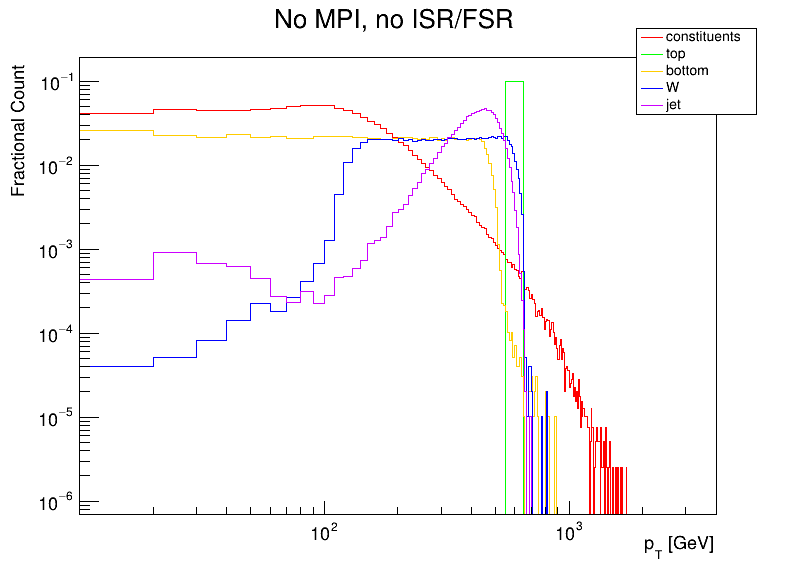

In [18]:
c, leg, hlist, hstack = KinematicDraw(E.keys(),pt, (400,0.,4000.), title + ';p_{T} [GeV];Fractional Count', True, True)
canvases.append(c)
legends.append(leg)
stacks.append(hstack)
for h in hlist: hists.append(h)

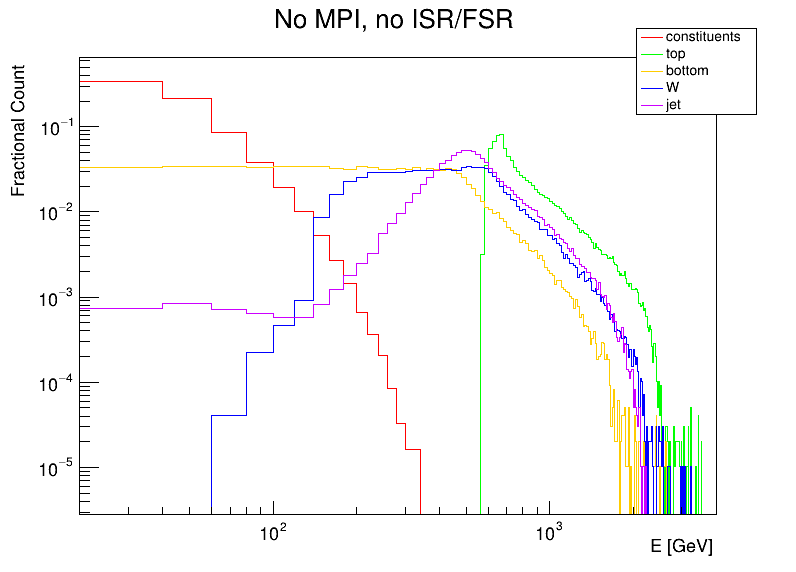

In [19]:
c, leg, hlist, hstack = KinematicDraw(E.keys(),E, (200,0.,4000.), title + ';E [GeV];Fractional Count', True, True)
canvases.append(c)
legends.append(leg)
stacks.append(hstack)
for h in hlist: hists.append(h)

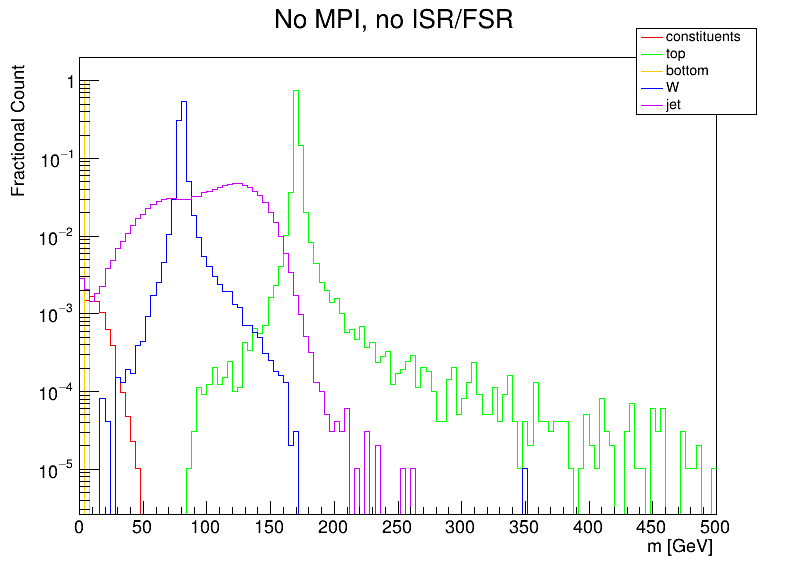

In [20]:
c, leg, hlist, hstack = KinematicDraw(E.keys(),m, (125,0.,500.), title + ';m [GeV];Fractional Count', False, True)
canvases.append(c)
legends.append(leg)
stacks.append(hstack)
for h in hlist: hists.append(h)

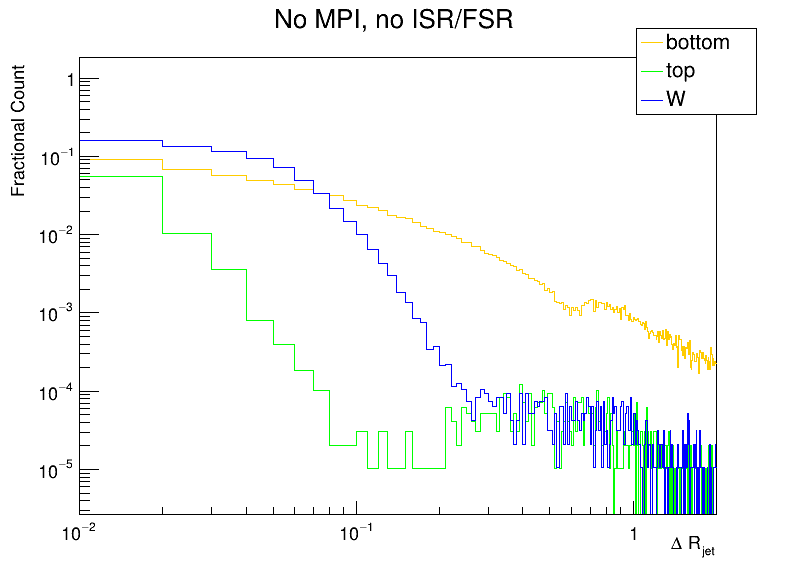

In [21]:
c, leg, hlist, hstack = KinematicDraw(dr.keys(),dr, (200,0.,2.), title + ';#Delta R_{jet};Fractional Count', True, True)
canvases.append(c)
legends.append(leg)
stacks.append(hstack)
for h in hlist: hists.append(h)

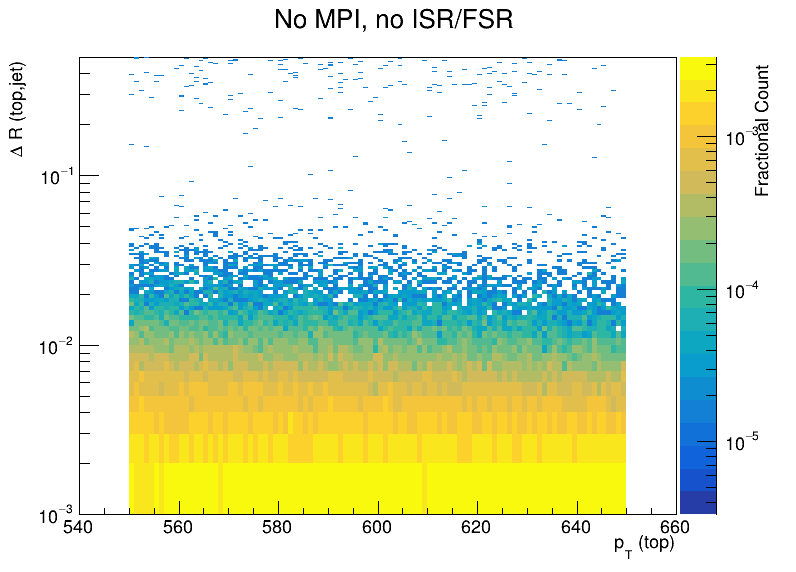

In [22]:
dr_title = title + ';p_{T} (top);#Delta R (top,jet);Fractional Count'
c_dr, h_dr = KinematicDraw2D(pt['top'], dr['top'], (120,540.,660.,500,1e-3,.5), dr_title, False, True)

In [ ]:
s = rt.THStack(qu.RN(),dr_title)
s.Add(h_dr)
canvases.append(c_dr)
stacks.append(s)

In [22]:
for i,c in enumerate(canvases): c.Write('c_{}'.format(i))
for i,s in enumerate(stacks): s.Write('s_{}'.format(i))
f.Close()